In [1]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# reading docfiles
import docx2txt

#nltk
import nltk
from nltk.tokenize import word_tokenize

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
word_exclusions = pd.read_excel("input/word_exclusions.xlsx")

word_exclusions = word_exclusions[word_exclusions["exclude"] == 1]

word_exclusions = word_exclusions.drop(columns=['exclude', 'exclude_short_list'], axis = 1)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
stop_words.extend(word_exclusions["word"])
stop_words.extend(["gut"])

In [4]:
df = pd.read_excel("input/app_v2/app_v2_feedback.xlsx")

In [5]:
df.head()

,transcript_id,person_id,segment_id,context,lesson,text,category_id
0,tn_01,p01,s_001,NaN,NaN,"Ja, ich höre Sie ein bisschen schlecht. Das ha...",2
1,tn_01,p01,s_002,NaN,NaN,"Ja, jetzt ist es ein bisschen besser. Ja.",2
2,tn_01,p01,s_003,"Ok, gut. Also… Ich habe jetzt das Aufnahmeger...",NaN,Ok. Ja.,1
3,tn_01,p01,s_004,NaN,NaN,"So ein Diktiergerät quasi. Ja, ja. Mhm.",2
4,tn_01,p01,s_005,Und ich spreche Sie jetzt auch nicht mit dem N...,NaN,"Ok, dann machen wir das so. Ja!",1


In [6]:
improvements = df[df["category_id"] == 10]

In [7]:
improvements = improvements.drop(columns=['transcript_id', 'person_id', 'segment_id', 'context', 'lesson', 'category_id'], 
             axis = 1)

In [8]:
improvements['text_processed'] = \
improvements['text'].map(lambda x: re.sub('[,.!?]', '', x))

In [9]:
improvements['text_processed'] = \
improvements['text_processed'].map(lambda x: x.lower())

In [10]:
feedback = improvements['text_processed']

feedback_token = feedback.apply(word_tokenize)
feedback_token.head()

23    [was, mir, nicht, gefallen, hat, sind, diese, ...
24    [genau…, dann, fand, ich, es, hat, sich, sehr,...
25    [ja, also, die, übungen, wo, man, irgendwie, e...
28    [*, lacht, *, da, ist, ja, eine, übung, und, i...
29    [dann, beim, punkt, neun, –, der, verhaltenspl...
Name: text_processed, dtype: object

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), 
                                             deacc = True))

In [12]:
data = improvements.text_processed.values.tolist()
data_words = list(sent_to_words(data))

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['was', 'mir', 'nicht', 'gefallen', 'hat', 'sind', 'diese', 'uberprufungen', 'einfach', 'weil', 'es', 'fur_mich', 'keinen', 'sinn', 'gemacht', 'hat', 'weil', 'ich', 'ja', 'dann', 'auch', 'nicht', 'wirklich', 'mehr', 'mit', 'arzten', 'gesprochen', 'habe', 'da', 'kam', 'ja', 'glaube', 'ich', 'drei', 'mal', 'oder', 'zwei', 'mal', 'kommt', 'ja', 'diese', 'uberprufung', 'zum', 'anfang', 'vom', 'introduction', 'kapitel', 'und', 'es', 'hat', 'sich', 'halt', 'nichts', 'geandert', 'an', 'meiner', 'kommunikation', 'mochte', 'ich', 'mal', 'behaupten']


In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(feedback_token)

In [16]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [17]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("de_core_news_sm", disable = ['parser', 'ner'])

In [18]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['fallen', 'überprüfungen', 'einfach', 'Sinn', 'machen', 'wirklich', 'mehr', 'ärzten', 'sprechen', 'kommen', 'glauben', 'kommen', 'Überprüfung', 'Anfang', 'Introduction', 'Kapitel', 'ändern', 'Kommunikation', 'behaupten']]


In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [20]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('Anfang', 1),
  ('Introduction', 1),
  ('Kapitel', 1),
  ('Kommunikation', 1),
  ('Sinn', 1),
  ('behaupten', 1),
  ('einfach', 1),
  ('fallen', 1),
  ('glauben', 1),
  ('kommen', 2),
  ('machen', 1),
  ('mehr', 1),
  ('sprechen', 1),
  ('wirklich', 1),
  ('Überprüfung', 1),
  ('ändern', 1),
  ('ärzten', 1),
  ('überprüfungen', 1)]]

In [21]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [22]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"vielleicht" + 0.023*"einfach" + 0.022*"finden" + 0.021*"sagen" + '
  '0.015*"bissch" + 0.013*"Frage" + 0.012*"Beispiel" + 0.012*"wirklich" + '
  '0.012*"geben" + 0.011*"immer"'),
 (1,
  '0.015*"machen" + 0.013*"wissen" + 0.011*"app" + 0.011*"Frage" + '
  '0.010*"finden" + 0.010*"vielleicht" + 0.009*"bissch" + 0.009*"immer" + '
  '0.008*"kommen" + 0.007*"denken"')]


In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.54075771501872

Coherence Score:  0.5550335347480755


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.070112  0.0       1        1  67.412196
1     -0.070112  0.0       2        1  32.587804, topic_info=         Term       Freq      Total Category  logprob  loglift
6     einfach  42.000000  42.000000  Default  30.0000  30.0000
63     wissen  21.000000  21.000000  Default  29.0000  29.0000
10     machen  26.000000  26.000000  Default  28.0000  28.0000
183       app  18.000000  18.000000  Default  27.0000  27.0000
297    selber   5.000000   5.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
136    Gefühl   3.582692   7.476541   Topic2  -5.5051   0.3856
60      sagen   6.181789  44.406229   Topic2  -4.9596  -0.8505
156      ganz   4.886941  21.470874   Topic2  -5.1947  -0.3589
24   Beispiel   5.078612  27.251149   Topic2  -5.1562  -0.5588
13   wirklich   4.405867  26.357844   Topic2  -5.2983  -0.6676

[150 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
501       1  0.924443     Alltag
485       2  0.874230    Antwort
466       1  1.029398   Babyzeit
24        1  0.807305   Beispiel
24        2  0.183478   Beispiel
...     ...       ...        ...
793       2  0.828354     wählen
260       2  0.967844       xxxx
554       1  1.029502  überlegen
50        1  0.456665      übung
50        2  0.684997      übung

[150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=num_topics, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=1, 
                                                        limit=10, 
                                                        step=1)

In [30]:
os.chdir("C:\\Users\\vanandkuma\\Documents\\projects\\sentiment_analysis")

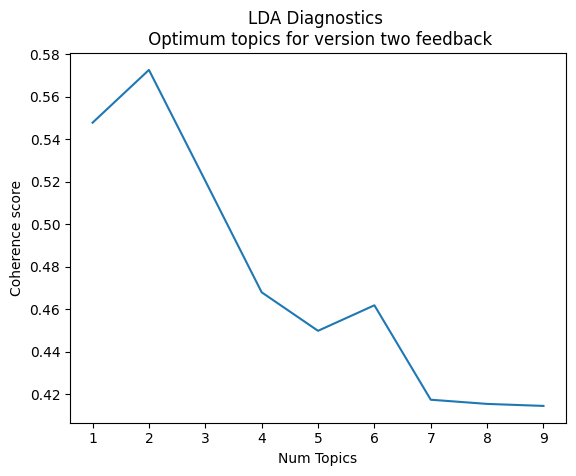

In [32]:
# Show graph
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.title("LDA Diagnostics \n Optimum topics for version two feedback")
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.savefig('output/app_v1_lda_topic_coherence.png')

In [33]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.5478
Num Topics = 2  has Coherence Value of 0.5727
Num Topics = 3  has Coherence Value of 0.5204
Num Topics = 4  has Coherence Value of 0.468
Num Topics = 5  has Coherence Value of 0.4498
Num Topics = 6  has Coherence Value of 0.4618
Num Topics = 7  has Coherence Value of 0.4174
Num Topics = 8  has Coherence Value of 0.4154
Num Topics = 9  has Coherence Value of 0.4145


In [30]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.056*"lernen" + 0.029*"mögen" + 0.029*"uber" + 0.026*"Frage" + '
  '0.020*"geben" + 0.019*"stellen" + 0.019*"fur" + 0.015*"personlich" + '
  '0.015*"Person" + 0.015*"hineinversetzen"'),
 (1,
  '0.052*"finden" + 0.041*"gut" + 0.029*"Lektion" + 0.020*"einfach" + '
  '0.020*"eigen" + 0.016*"Kommunikation" + 0.013*"Klicke" + 0.013*"personlich" '
  '+ 0.012*"kurz" + 0.011*"mögen"'),
 (2,
  '0.055*"gut" + 0.055*"finden" + 0.035*"Beispiel" + 0.021*"immer" + '
  '0.018*"geben" + 0.018*"Alltag" + 0.013*"personlich" + 0.013*"wichtig" + '
  '0.013*"mögen" + 0.013*"wirklich"'),
 (3,
  '0.027*"Thema" + 0.024*"nie" + 0.024*"bissch" + 0.024*"mögen" + '
  '0.023*"Geburt" + 0.020*"Seite" + 0.020*"finden" + 0.017*"Kommunikation" + '
  '0.016*"fur" + 0.014*"spannend"'),
 (4,
  '0.051*"Lektion" + 0.039*"gut" + 0.039*"Idee" + 0.026*"mögen" + '
  '0.026*"finden" + 0.026*"kommen" + 0.014*"total" + 0.014*"folgen" + '
  '0.014*"dazwischen" + 0.014*"Kleinigkeit"'),
 (5,
  '0.077*"mögen" + 0.028*"neutra

In [26]:
pyLDAvis.save_html(vis, 'output/ldavis_app_v2_improvements.html')

C:\Users\vanandkuma\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_memmapping_reducer.py:611: UserWarning: Failed to delete temporary folder: C:\Users\VANAND~1\AppData\Local\Temp\joblib_memmapping_folder_125520_ea82bf33d87b4bbdba3d89e13caa6aba_803323dde39c4dce8d6e56c9ba1d6309
  warnings.warn("Failed to delete temporary folder: {}"
C:\Users\vanandkuma\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\_memmapping_reducer.py:611: UserWarning: Failed to delete temporary folder: C:\Users\VANAND~1\AppData\Local\Temp\joblib_memmapping_folder_125520_ea82bf33d87b4bbdba3d89e13caa6aba_fbd517443f82406b9a88eb3ce37d6713
  warnings.warn("Failed to delete temporary folder: {}"
